In [73]:
!pip install adjustText

In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from adjustText import adjust_text


Transform topic distribution files into more usable format for merging in topic names 

In [39]:
def extract_topic_names(topic_names_file):
    topic_names = []
    with open(topic_names_file, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith("Topic"):
                parts = line.split(":")
                topic_id = int(parts[0].replace("Topic", "").strip())
                match = re.search(r'"(.+?)"', line)
                topic_name = match.group(1) if match else "Unnamed Topic"
                top_words = parts[1].split(" - ")[1].strip() if " - " in parts[1] else ""

                topic_names.append({
                    "Topic_ID": topic_id,
                    "Topic_Name": topic_name,
                    "Top_Words": top_words
                })
    return pd.DataFrame(topic_names)

def extract_topic_distributions(topic_distribution_file):
    topic_distributions = []
    with open(topic_distribution_file, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith("Document"):
                doc_id = int(line.split(":")[0].replace("Document", "").strip())
                topic_tuples = eval(line.split(":")[1].strip())
                for topic_id, proportion in topic_tuples:
                    topic_distributions.append({
                        "Document_ID": doc_id,
                        "Topic_ID": topic_id,
                        "Topic_Proportion": proportion
                    })
    return pd.DataFrame(topic_distributions)

def process_and_save_all_periods(output_parent_folder, orientations, periods_and_topics):
    for orientation in orientations:
        for period, num_topics in periods_and_topics[orientation].items():
            print(f"Processing topic distributions for {orientation} during {period}...")
            topic_names_file = os.path.join(output_parent_folder, orientation, period, f"topic_names_{period}_{num_topics}_topics.txt")
            topic_distribution_file = os.path.join(output_parent_folder, orientation, period, f"topic_document_distribution_{period}_{num_topics}_topics.txt")
            if not os.path.exists(topic_names_file) or not os.path.exists(topic_distribution_file):
                print(f"Files not found for {orientation} during {period}.")
                continue

            topic_names_df = extract_topic_names(topic_names_file)
            topic_distributions_df = extract_topic_distributions(topic_distribution_file)
            merged_df = pd.merge(topic_distributions_df, topic_names_df, on="Topic_ID", how="left")

            merged_df['Orientation'] = orientation
            merged_df['Period'] = period

            output_folder = os.path.join(output_parent_folder, 'LDA_visualisations')
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
            
            output_file = os.path.join(output_folder, f"merged_topic_data_{orientation}_{period}.csv")
            merged_df.to_csv(output_file, index=False)
            print(f"Saved merged data for {orientation} during {period} to {output_file}")


output_parent_folder = r'/Users/mty925/Documents/Dissertation/lda_model_outputs'


orientations = ['centre-left', 'centre-right']
periods_and_topics = {
    'centre-left': {
        '1988-1997': 4,
        '1998-2007': 15,
        '2008-2016': 23
    },
    'centre-right': {
        '1988-1997': 8,
        '1998-2007': 15,
        '2008-2016': 15
    }
}

process_and_save_all_periods(output_parent_folder, orientations, periods_and_topics)


Processing topic distributions for centre-left during 1988-1997...
Saved merged data for centre-left during 1988-1997 to /Users/mty925/Documents/Dissertation/lda_model_outputs/LDA_visualisations/merged_topic_data_centre-left_1988-1997.csv
Processing topic distributions for centre-left during 1998-2007...
Saved merged data for centre-left during 1998-2007 to /Users/mty925/Documents/Dissertation/lda_model_outputs/LDA_visualisations/merged_topic_data_centre-left_1998-2007.csv
Processing topic distributions for centre-left during 2008-2016...
Saved merged data for centre-left during 2008-2016 to /Users/mty925/Documents/Dissertation/lda_model_outputs/LDA_visualisations/merged_topic_data_centre-left_2008-2016.csv
Processing topic distributions for centre-right during 1988-1997...
Saved merged data for centre-right during 1988-1997 to /Users/mty925/Documents/Dissertation/lda_model_outputs/LDA_visualisations/merged_topic_data_centre-right_1988-1997.csv
Processing topic distributions for centre

In [40]:
def combine_all_files(output_folder):
    all_files = [f for f in os.listdir(output_folder) if f.endswith('.csv')]
    combined_df = pd.concat([pd.read_csv(os.path.join(output_folder, f)) for f in all_files], ignore_index=True)
    combined_output_file = os.path.join(output_folder, "combined_topic_data.csv")
    combined_df.to_csv(combined_output_file, index=False)
    print(f"Combined data saved to {combined_output_file}")

output_folder = r'/Users/mty925/Documents/Dissertation/lda_model_outputs/LDA_visualisations'
combine_all_files(output_folder)


Combined data saved to /Users/mty925/Documents/Dissertation/lda_model_outputs/LDA_visualisations/combined_topic_data.csv


Full list of topics 

In [53]:
combined_data_path = r'/Users/mty925/Documents/Dissertation/lda_model_outputs/LDA_visualisations/combined_topic_data.csv'
df = pd.read_csv(combined_data_path)
unique_topics = df['Topic_Name'].unique()
for topic in unique_topics:
    print(topic)


Domestic Politics
Environmental Impact: Flooding
Environmental Impact: Ecosystem
Environmental Policy: Domestic & International
Household Energy Supply
Leisure & Tourism
Tackling Emissions
Rising Temperatures: Impact
Energy Production: Biofuels
American Politics
Topic Excluded: Incoherent
Media & Entertainment
Education & Childhood
Domestic Politics: Taxation & Government Spending
International Climate Policy
Sustainability: Community Action
American Politics: Clinton Vs Trump
Climate Activism: Protests
American Politics: Obama Presidency
Economy & Financial Markets
Environmental Impact: Great Barrier Reef
Domestic Politics: EU Referendum
International & Domestic Politics
Climate Science
Education
Environmental Impact: Melting Ice
Energy Production: Renewables
Climate Uncertainty
Media & Entertainment: TV Guide
Topic Excluded: Poor Underlying Data
Fashion Industry
Energy Production
Environmental Impact
Car Industry
Sustainability: Business
Household Energy Supply:Consumer Bills
Topic E

Calculating most prevelant topics irrespective of time period or orientation

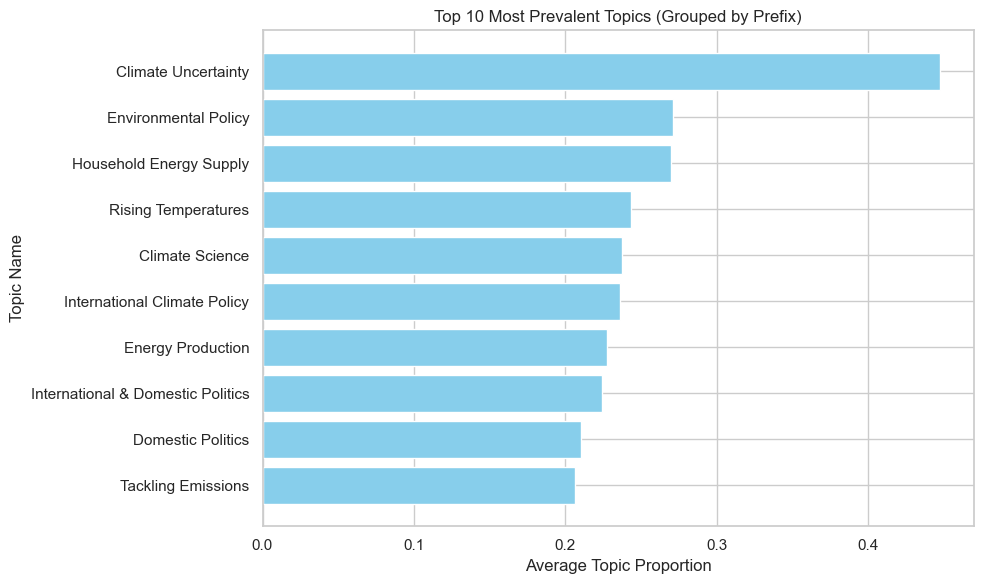

In [54]:
combined_data_path = r'/Users/mty925/Documents/Dissertation/lda_model_outputs/LDA_visualisations/combined_topic_data.csv'
df = pd.read_csv(combined_data_path)

#  grouping topics
def group_by_prefix(topic_name):
    if ":" in topic_name:
        return topic_name.split(":")[0].strip()  
    else:
        return topic_name 
df['Grouped_Topic'] = df['Topic_Name'].apply(group_by_prefix)

def plot_top_10_topics(df, title, save_path):
    top_10 = (
        df.groupby('Grouped_Topic')['Topic_Proportion']
        .mean()
        .sort_values(ascending=False)
        .head(10)
        .reset_index()
    )

    plt.figure(figsize=(10, 6))
    plt.barh(top_10['Grouped_Topic'], top_10['Topic_Proportion'], color='skyblue')
    plt.xlabel('Average Topic Proportion')
    plt.ylabel('Topic Name')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

plot_top_10_topics(
    df,
    'Top 10 Most Prevalent Topics (Grouped by Prefix)',
    r'/Users/mty925/Documents/Dissertation/LDA_visualisations/top_10_overall_grouped.png'
)


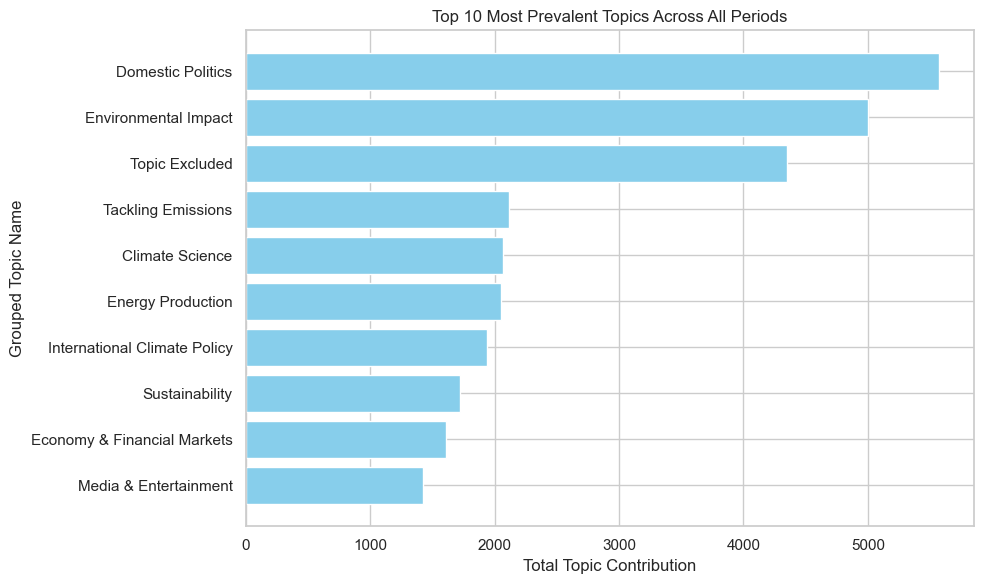

Top 10 grouped topics plot saved to /Users/mty925/Documents/Dissertation/LDA_visualisations/top_10_grouped_topics_overall.png


In [55]:
file_path = '/Users/mty925/Documents/Dissertation/lda_model_outputs/LDA_visualisations/combined_topic_data.csv'
df = pd.read_csv(file_path)

df['Grouped_Topic_Name'] = df['Topic_Name'].apply(lambda x: x.split(":")[0] if ":" in x else x)

grouped_topics = (
    df.groupby('Grouped_Topic_Name')['Topic_Proportion']
    .sum()
    .reset_index()
)

top_10_grouped_topics = grouped_topics.sort_values(by='Topic_Proportion', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_grouped_topics['Grouped_Topic_Name'], top_10_grouped_topics['Topic_Proportion'], color='skyblue')
plt.xlabel('Total Topic Contribution')
plt.ylabel('Grouped Topic Name')
plt.title('Top 10 Most Prevalent Topics Across All Periods')
plt.gca().invert_yaxis()  
plt.grid(True)
plt.tight_layout()

output_plot_path = '/Users/mty925/Documents/Dissertation/LDA_visualisations/top_10_grouped_topics_overall.png'
plt.savefig(output_plot_path)
plt.show()

print(f"Top 10 grouped topics plot saved to {output_plot_path}")


Topic prevalence based on orientation 

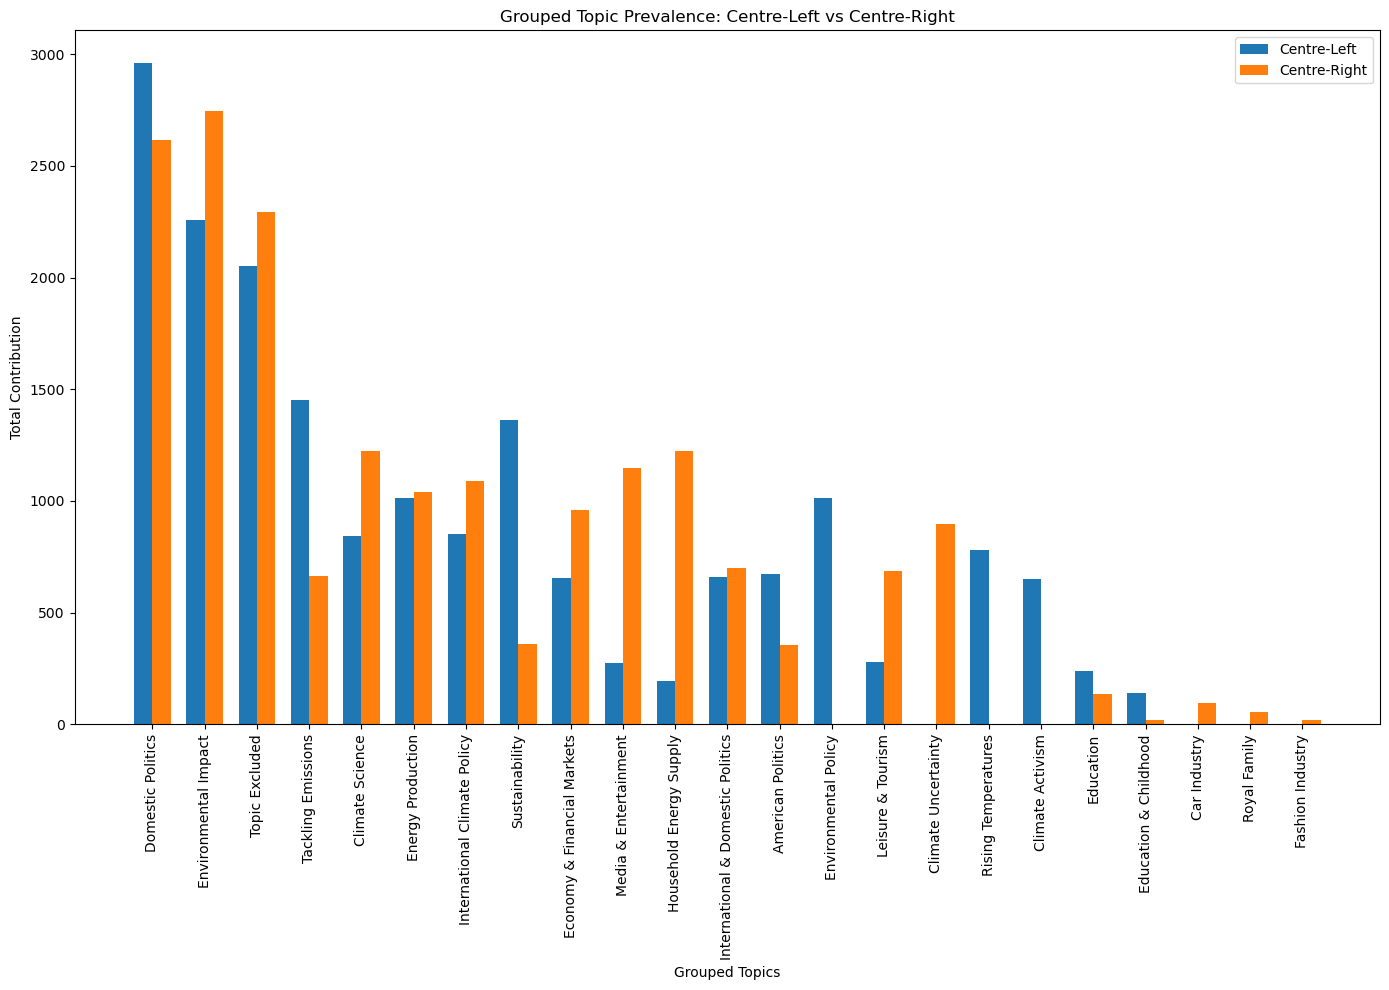

In [2]:
df = pd.read_csv('/Users/mty925/Documents/Dissertation/lda_model_outputs/LDA_visualisations/combined_topic_data.csv')

def extract_prefix(topic_name):
    if ':' in topic_name:
        return topic_name.split(':')[0].strip()
    else:
        return topic_name

df['Grouped_Topic'] = df['Topic_Name'].apply(extract_prefix)
topic_contributions = df.groupby(['Orientation', 'Grouped_Topic'])['Topic_Proportion'].sum().unstack().fillna(0)
sorted_topic_contributions = topic_contributions.sum().sort_values(ascending=False)
filtered_topic_contributions = topic_contributions.loc[:, sorted_topic_contributions.index]


x = np.arange(len(filtered_topic_contributions.columns))  
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))  

rects1 = ax.bar(x - width/2, filtered_topic_contributions.loc['centre-left'], width, label='Centre-Left')
rects2 = ax.bar(x + width/2, filtered_topic_contributions.loc['centre-right'], width, label='Centre-Right')
ax.set_xlabel('Grouped Topics')
ax.set_ylabel('Total Contribution')
ax.set_title('Grouped Topic Prevalence: Centre-Left vs Centre-Right')
ax.set_xticks(x)
ax.set_xticklabels(filtered_topic_contributions.columns, rotation=90, ha='center')
ax.legend()


fig.tight_layout()


plt.savefig('/Users/mty925/Documents/Dissertation/LDA_visualisations/grouped_topic_prevalence_centre_left_vs_right.png')
plt.show()


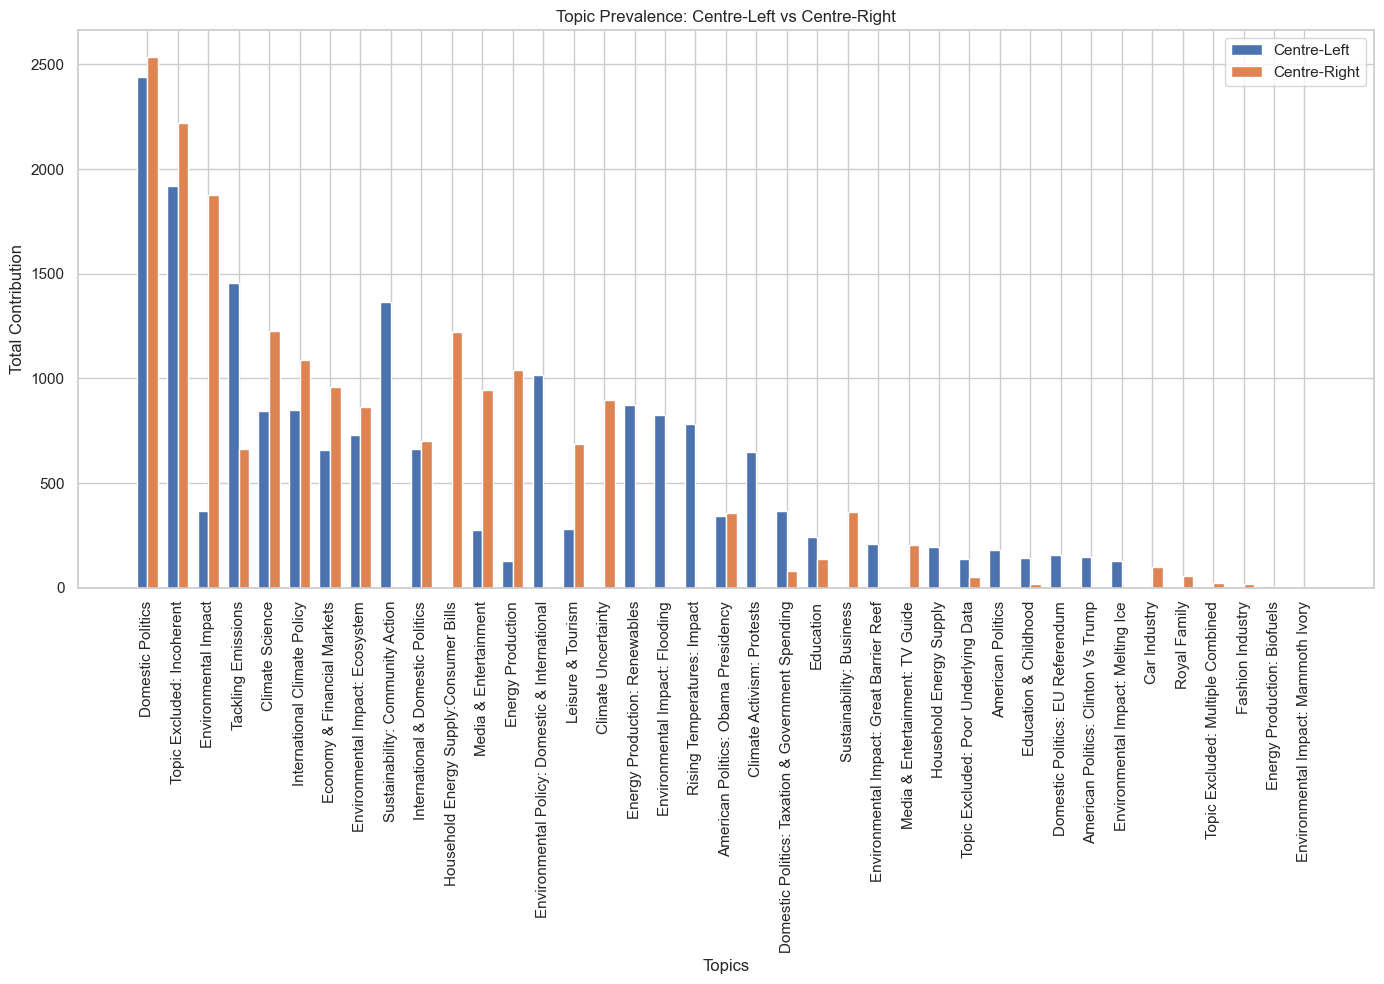

In [62]:

df = pd.read_csv('/Users/mty925/Documents/Dissertation/lda_model_outputs/LDA_visualisations/combined_topic_data.csv')

topic_contributions = df.groupby(['Orientation', 'Topic_Name'])['Topic_Proportion'].sum().unstack().fillna(0)
sorted_topic_contributions = topic_contributions.sum().sort_values(ascending=False)
filtered_topic_contributions = topic_contributions.loc[:, sorted_topic_contributions.index]

x = np.arange(len(filtered_topic_contributions.columns))  
width = 0.35  

fig, ax = plt.subplots(figsize=(14, 10))

rects1 = ax.bar(x - width/2, filtered_topic_contributions.loc['centre-left'], width, label='Centre-Left')
rects2 = ax.bar(x + width/2, filtered_topic_contributions.loc['centre-right'], width, label='Centre-Right')

ax.set_xlabel('Topics')
ax.set_ylabel('Total Contribution')
ax.set_title('Topic Prevalence: Centre-Left vs Centre-Right')
ax.set_xticks(x)
ax.set_xticklabels(filtered_topic_contributions.columns, rotation=90, ha='center')
ax.legend()
fig.tight_layout()


plt.savefig('/Users/mty925/Documents/Dissertation/LDA_visualisations/topic_prevalence_centre_left_vs_right.png')
plt.show()


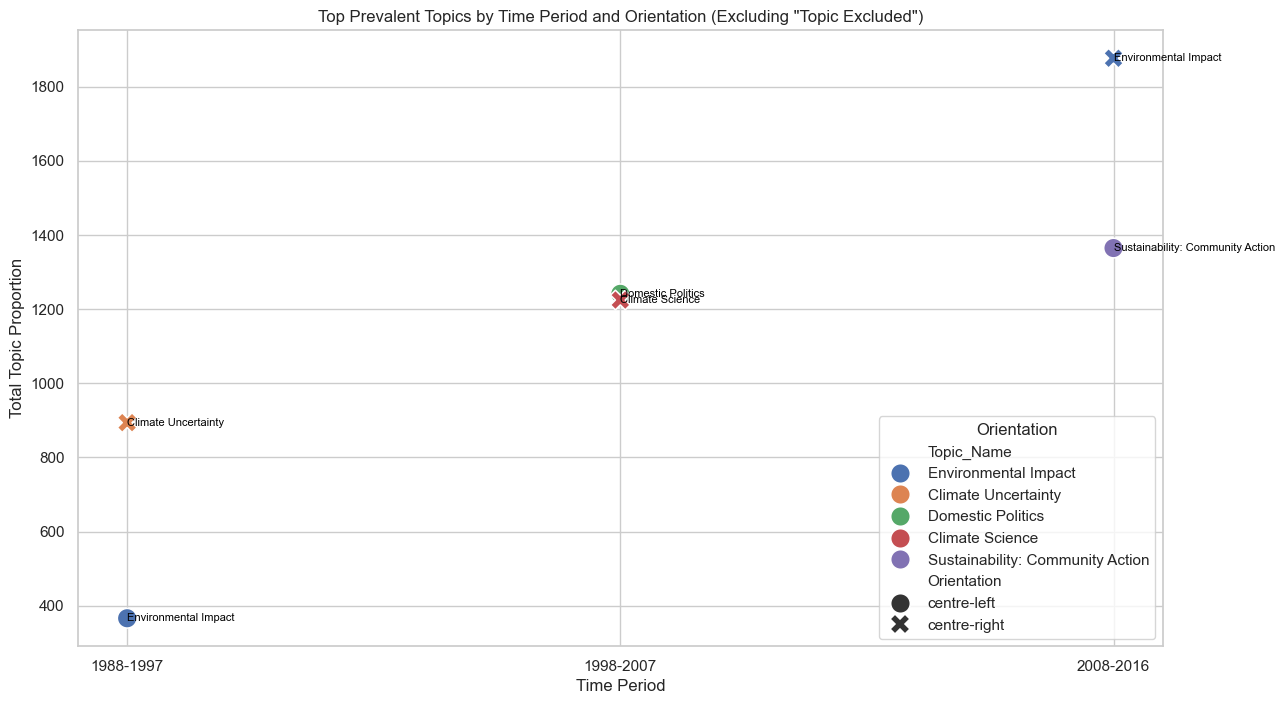

In [68]:
df = pd.read_csv('/Users/mty925/Documents/Dissertation/lda_model_outputs/LDA_visualisations/combined_topic_data.csv')

df = df[~df['Topic_Name'].str.contains("Topic Excluded")]
grouped_df = df.groupby(['Period', 'Orientation', 'Topic_Name'])['Topic_Proportion'].sum().reset_index()
grouped_df = grouped_df.sort_values(by=['Period', 'Orientation'])
top_topics_df = grouped_df.loc[grouped_df.groupby(['Period', 'Orientation'])['Topic_Proportion'].idxmax()]


plt.figure(figsize=(14, 8))
sns.scatterplot(data=top_topics_df, x='Period', y='Topic_Proportion', hue='Topic_Name', style='Orientation', s=200)
for i in range(top_topics_df.shape[0]):
    plt.text(
        x=top_topics_df['Period'].iloc[i], 
        y=top_topics_df['Topic_Proportion'].iloc[i],  
        s=top_topics_df['Topic_Name'].iloc[i], 
        horizontalalignment='left',  
        verticalalignment='center',
        fontsize=8, 
        color='black'
    )

plt.title('Top Prevalent Topics by Time Period and Orientation (Excluding "Topic Excluded")')
plt.xlabel('Time Period')
plt.ylabel('Total Topic Proportion')
plt.grid(True)
plt.legend(title='Orientation', loc='lower right')
plt.savefig('/Users/mty925/Documents/Dissertation/LDA_visualisations/top_topics_scatter_excluded_with_legend.png', bbox_inches='tight')
plt.show()


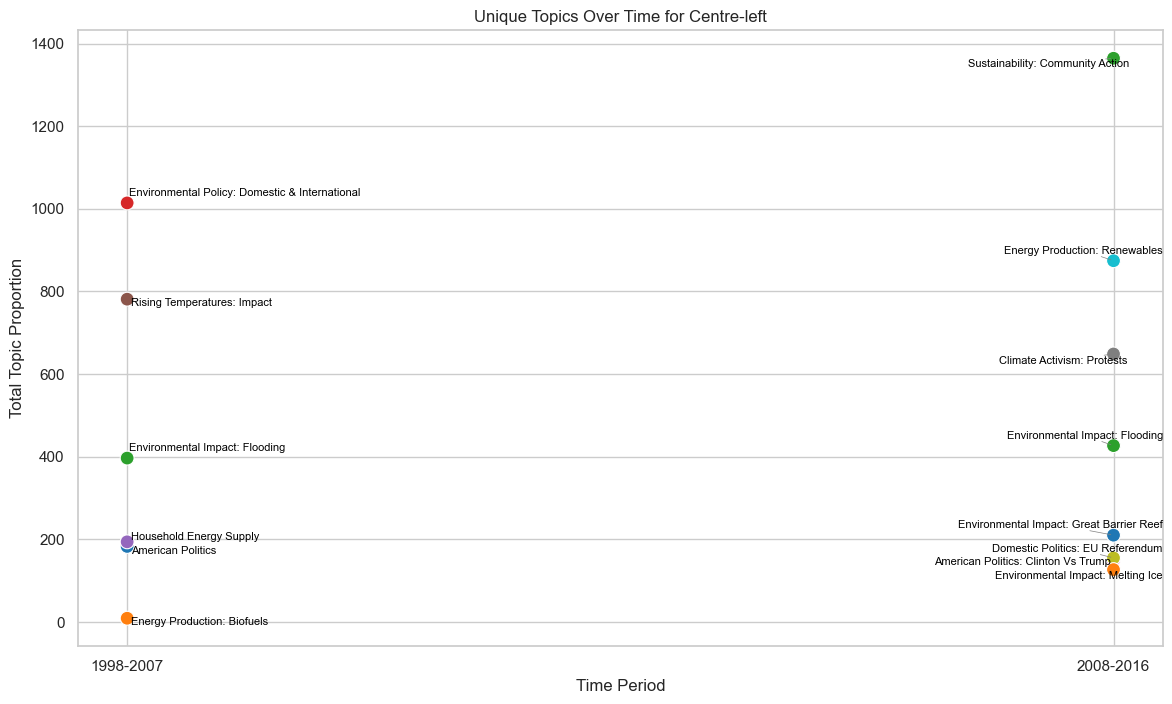

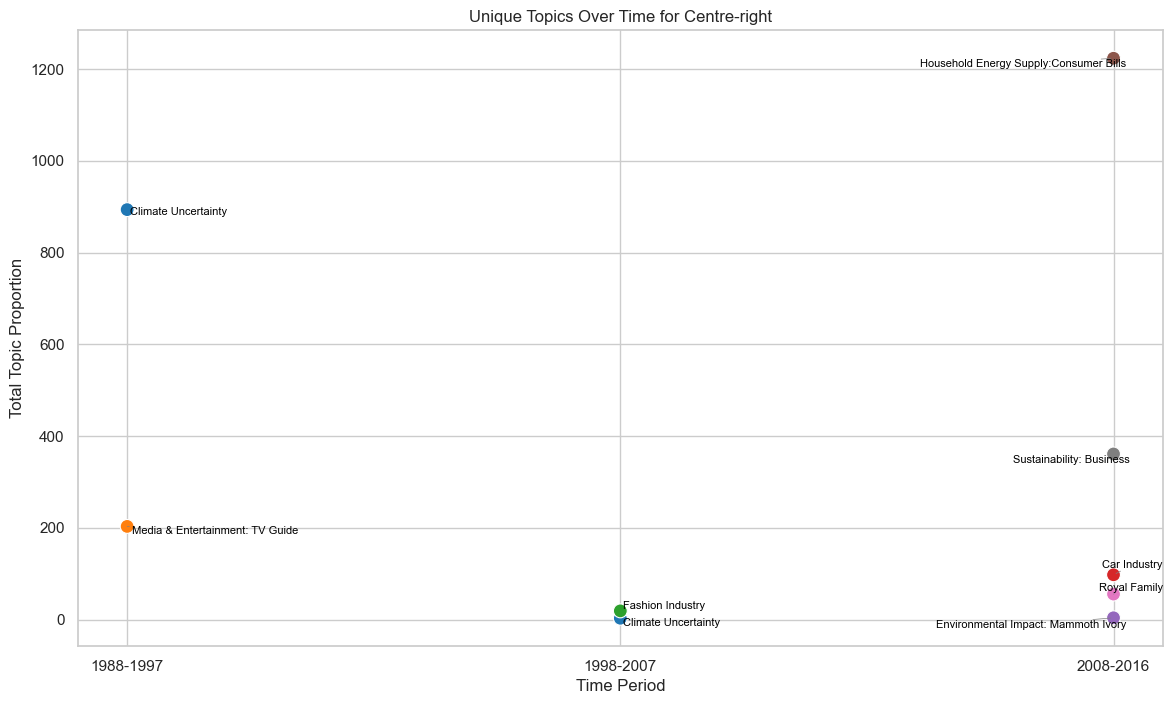

In [74]:
df = pd.read_csv('/Users/mty925/Documents/Dissertation/lda_model_outputs/LDA_visualisations/combined_topic_data.csv')
df = df[~df['Topic_Name'].str.contains("Topic Excluded")]


left_unique_topics = set(df[df['Orientation'] == 'centre-left']['Topic_Name']) - set(df[df['Orientation'] == 'centre-right']['Topic_Name'])
right_unique_topics = set(df[df['Orientation'] == 'centre-right']['Topic_Name']) - set(df[df['Orientation'] == 'centre-left']['Topic_Name'])
left_unique_df = df[(df['Orientation'] == 'centre-left') & (df['Topic_Name'].isin(left_unique_topics))]
right_unique_df = df[(df['Orientation'] == 'centre-right') & (df['Topic_Name'].isin(right_unique_topics))]

def plot_unique_topics_over_time(unique_df, orientation, output_path):
    grouped_df = unique_df.groupby(['Period', 'Topic_Name'])['Topic_Proportion'].sum().reset_index()

    plt.figure(figsize=(14, 8))
    scatter = sns.scatterplot(
        data=grouped_df, 
        x='Period', 
        y='Topic_Proportion', 
        hue='Topic_Name', 
        palette='tab10',
        s=100,  
        legend=False 
    )

  
    texts = []
    for i in range(grouped_df.shape[0]):
        texts.append(plt.text(
            x=grouped_df['Period'].iloc[i], 
            y=grouped_df['Topic_Proportion'].iloc[i],  
            s=grouped_df['Topic_Name'].iloc[i], 
            horizontalalignment='left',  
            verticalalignment='center',
            fontsize=8, 
            color='black'
        ))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))


    plt.title(f'Unique Topics Over Time for {orientation.capitalize()}')
    plt.xlabel('Time Period')
    plt.ylabel('Total Topic Proportion')
    plt.grid(True)
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()

plot_unique_topics_over_time(
    left_unique_df, 
    'centre-left', 
    '/Users/mty925/Documents/Dissertation/LDA_visualisations/unique_topics_centre_left_over_time.png'
)

plot_unique_topics_over_time(
    right_unique_df, 
    'centre-right', 
    '/Users/mty925/Documents/Dissertation/LDA_visualisations/unique_topics_centre_right_over_time.png'
)


/var/folders/nr/vnlmxd5s6tz1d1mf250dny6r0000gp/T/ipykernel_59874/834567420.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=grouped_excluded_df, x='Period', y='Topic_Proportion', hue='Orientation', ci=None)


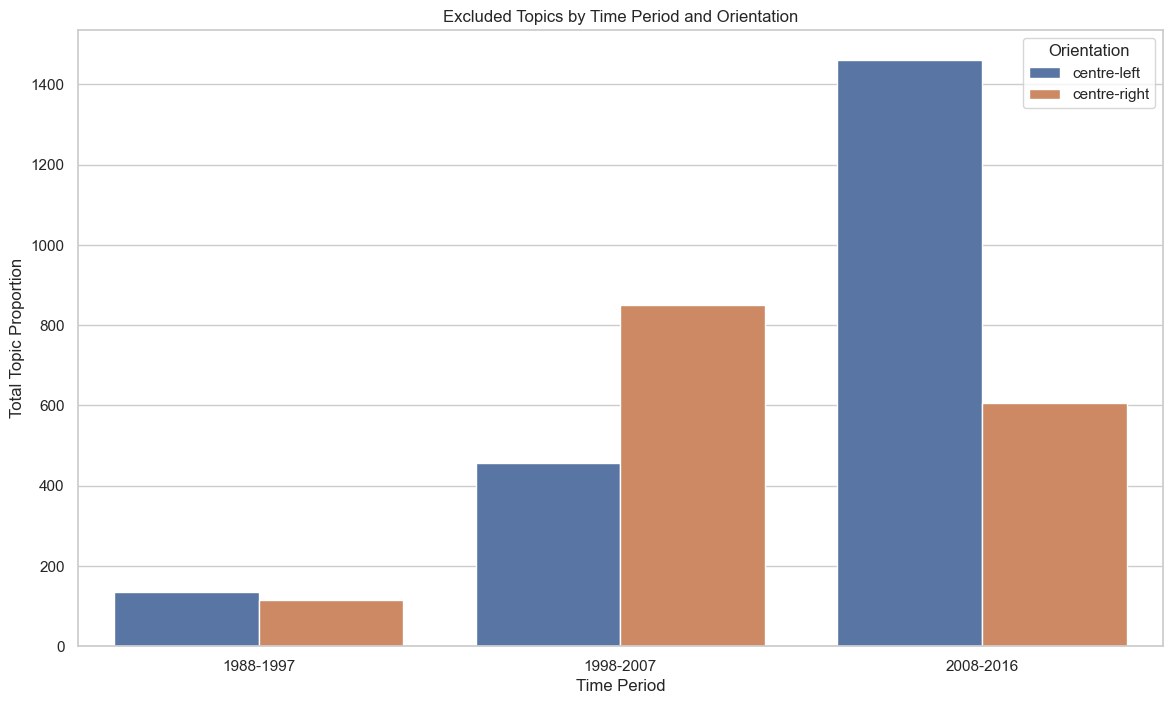

In [75]:
df = pd.read_csv('/Users/mty925/Documents/Dissertation/lda_model_outputs/LDA_visualisations/combined_topic_data.csv')


excluded_topics_df = df[df['Topic_Name'].str.contains("Topic Excluded")]
grouped_excluded_df = excluded_topics_df.groupby(['Period', 'Orientation', 'Topic_Name'])['Topic_Proportion'].sum().reset_index()
grouped_excluded_df = grouped_excluded_df.sort_values(by=['Period', 'Orientation'])

plt.figure(figsize=(14, 8))
sns.barplot(data=grouped_excluded_df, x='Period', y='Topic_Proportion', hue='Orientation', ci=None)
plt.title('Excluded Topics by Time Period and Orientation')
plt.xlabel('Time Period')
plt.ylabel('Total Topic Proportion')
plt.grid(True, axis='y')
plt.legend(title='Orientation', loc='upper right')
plt.savefig('/Users/mty925/Documents/Dissertation/LDA_visualisations/excluded_topics_by_period_orientation.png', bbox_inches='tight')
plt.show()


In [1]:
df = pd.read_csv('/Users/mty925/Documents/Dissertation/lda_model_outputs/LDA_visualisations/combined_topic_data.csv')

excluded_topics_df = df[df['Topic_Name'].str.contains("Topic Excluded")]
excluded_topic_counts = excluded_topics_df.groupby(['Period', 'Orientation'])['Topic_Name'].nunique().reset_index()
excluded_topic_counts.columns = ['Period', 'Orientation', 'Excluded_Topic_Count']
excluded_topic_counts = excluded_topic_counts.sort_values(by=['Period', 'Orientation'])

print(excluded_topic_counts)
excluded_topic_counts.to_csv('/Users/mty925/Documents/Dissertation/LDA_visualisations/excluded_topic_counts.csv', index=False)


      Period   Orientation  Excluded_Topic_Count
0  1988-1997   centre-left                     1
1  1988-1997  centre-right                     2
2  1998-2007   centre-left                     1
3  1998-2007  centre-right                     1
4  2008-2016   centre-left                     1
5  2008-2016  centre-right                     2


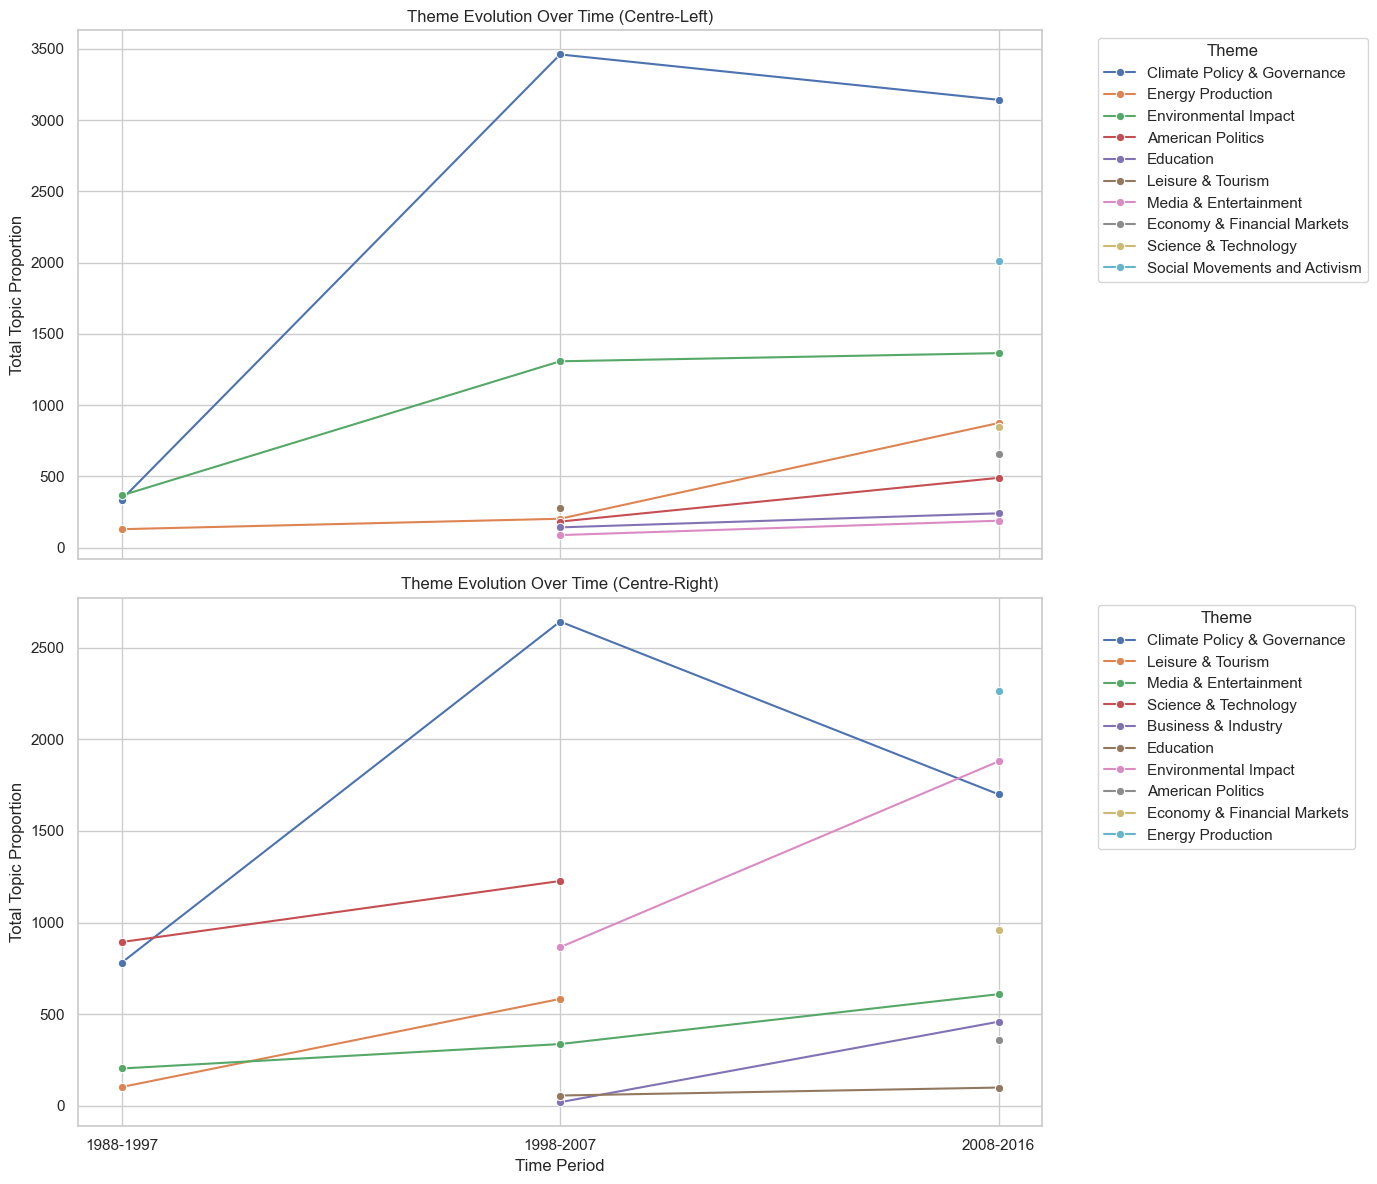

In [76]:
df = pd.read_csv('/Users/mty925/Documents/Dissertation/lda_model_outputs/LDA_visualisations/combined_topic_data.csv')
df = df[~df['Topic_Name'].str.contains("Topic Excluded")]

topic_to_theme_mapping = {
    "Domestic Politics": "Climate Policy & Governance",
    "Environmental Impact: Flooding": "Environmental Impact",
    "Environmental Impact: Ecosystem": "Environmental Impact",
    "Environmental Policy: Domestic & International": "Climate Policy & Governance",
    "Household Energy Supply": "Energy Production",
    "Leisure & Tourism": "Leisure & Tourism",
    "Tackling Emissions": "Climate Policy & Governance",
    "Rising Temperatures: Impact": "Environmental Impact",
    "Energy Production: Biofuels": "Energy Production",
    "American Politics": "American Politics",
    "Media & Entertainment": "Media & Entertainment",
    "Education & Childhood": "Education",
    "Domestic Politics: Taxation & Government Spending": "Climate Policy & Governance",
    "International Climate Policy": "Climate Policy & Governance",
    "Sustainability: Community Action": "Social Movements and Activism",
    "American Politics: Clinton Vs Trump": "American Politics",
    "Climate Activism: Protests": "Social Movements and Activism",
    "American Politics: Obama Presidency": "American Politics",
    "Economy & Financial Markets": "Economy & Financial Markets",
    "Environmental Impact: Great Barrier Reef": "Environmental Impact",
    "Domestic Politics: EU Referendum": "Climate Policy & Governance",
    "International & Domestic Politics": "Climate Policy & Governance",
    "Climate Science": "Science & Technology",
    "Education": "Education",
    "Environmental Impact: Melting Ice": "Environmental Impact",
    "Energy Production: Renewables": "Energy Production",
    "Climate Uncertainty": "Science & Technology",
    "Media & Entertainment: TV Guide": "Media & Entertainment",
    "Fashion Industry": "Business & Industry",
    "Energy Production": "Energy Production",
    "Environmental Impact": "Environmental Impact",
    "Car Industry": "Business & Industry",
    "Sustainability: Business": "Business & Industry",
    "Household Energy Supply:Consumer Bills": "Energy Production",
    "Royal Family": "Climate Policy & Governance",
    "Environmental Impact: Mammoth Ivory": "Environmental Impact"
}

df['Theme'] = df['Topic_Name'].map(topic_to_theme_mapping)

grouped_df = df.groupby(['Period', 'Orientation', 'Theme'])['Topic_Proportion'].sum().reset_index()

fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

sns.lineplot(
    data=grouped_df[grouped_df['Orientation'] == 'centre-left'],
    x='Period', y='Topic_Proportion', hue='Theme', marker='o', ax=axes[0]
)
axes[0].set_title('Theme Evolution Over Time (Centre-Left)')
axes[0].set_ylabel('Total Topic Proportion')
axes[0].grid(True, axis='y')

sns.lineplot(
    data=grouped_df[grouped_df['Orientation'] == 'centre-right'],
    x='Period', y='Topic_Proportion', hue='Theme', marker='o', ax=axes[1]
)
axes[1].set_title('Theme Evolution Over Time (Centre-Right)')
axes[1].set_ylabel('Total Topic Proportion')
axes[1].grid(True, axis='y')
axes[0].legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Time Period')
plt.tight_layout()

plt.savefig('/Users/mty925/Documents/Dissertation/LDA_visualisations/theme_evolution_over_time_by_orientation.png', bbox_inches='tight')
plt.show()
